In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [3]:
df = pd.read_csv('C:/Users/flath/Desktop/Ml.b/train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [6]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

### LogisticRegression

Добавим классификатор и запустим кросс-валидацию

In [7]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])


# запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

# обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7864573689384385+-0.004422021036885763


Посчитаем precision/recall/f_score

In [8]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
fin_dict={
    'model':['LogReg'],
    'F-score':[fscore[ix]],
    'Precision':[precision[ix]],
    'Recall':[recall[ix]]
    
}

Best Threshold=0.3869370891147365, F-Score= 0.730, Precision= 0.647, Recall= 0.838


In [9]:
def roc_auc_plot(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.text(0,1,f'ROC-AUC_SCORE{roc_auc_score(y_test,y_score): .3f}')
    #plt.savefig("ROC.png")
    plt.show()

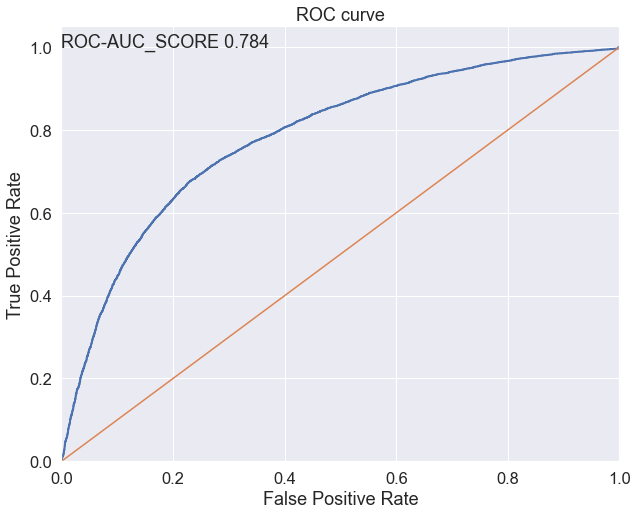

In [10]:
roc_auc_plot(y_test, y_score)

In [11]:
fin_dict.update({'ROC-AUC-SCORE':[roc_auc_score(y_test, y_score)]})

In [12]:
from sklearn.metrics import roc_auc_score

print(f"roc auc score: {roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])}")

print(f"roc auc score: {roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])}")

roc auc score: 0.7870081561637485
roc auc score: 0.7840347790421852


In [13]:
import itertools

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


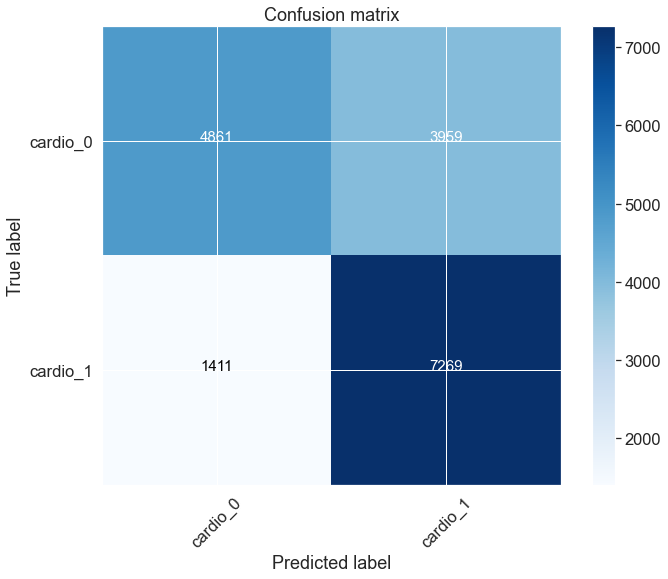

In [15]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_log = confusion_matrix(y_test, y_score > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_log, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [16]:
TN = cnf_matrix_log[0][0]
FN = cnf_matrix_log[1][0]
TP = cnf_matrix_log[1][1]
FP = cnf_matrix_log[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

Пусть:

- стоимость лечения 15000р, если сделали тест и начали лечить вовремя
- стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 1400р



- лишних тестов сделали FP = cnf_matrix[0][1]
- пропустили больных FN = cnf_matrix[1][0]
- правильных тестов сделали TP = cnf_matrix[1][1]

Оценим расходы, если не делать тест и ждать симптомов:


In [17]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

In [18]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать МЛ:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)
    
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152712400
Расходы "решение не делать тесты - расходы с МL:" 20887600
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 1987600


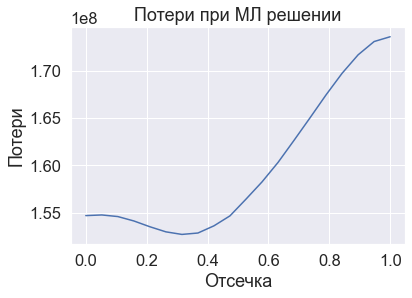

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.3869370891147365


In [19]:
busines_tr = business_threshold_calibrate(y_test, y_score, 
                                          thresholds[ix],
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds[ix])

### GradientBoostingClassifier

In [20]:
parameters_gb = {
     'n_estimators': [100, 150, 200, 600, 1000],
     'max_depth': np.arange(2, 10, 2),
 }
clf = GridSearchCV(estimator=GradientBoostingClassifier(random_state=0), param_grid=parameters_gb, scoring='roc_auc', cv=5)
clf.fit(X_train, y_train)
clf.best_params_

KeyboardInterrupt: 

In [21]:
classifier_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier( max_depth=4, n_estimators=100,random_state=0))])

In [22]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_gb, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

CV score is 0.8026147309734324+-0.0069670896831472


In [23]:
#обучим пайплайн на всем тренировочном датасете
classifier_gb.fit(X_train, y_train)
y_score_gb = classifier_gb.predict_proba(X_test)[:, 1]

In [24]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_gb)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
new_list=['GradBoost',fscore[ix],precision[ix], recall[ix], roc_auc_score(y_test, y_score_gb)]
for i, (key, val) in enumerate(fin_dict.items()):
    fin_dict[key].append(new_list[i])

Best Threshold=0.365865538275279, F-Score= 0.740, Precision= 0.676, Recall= 0.816


Confusion matrix, without normalization
[[5431 3389]
 [1595 7085]]


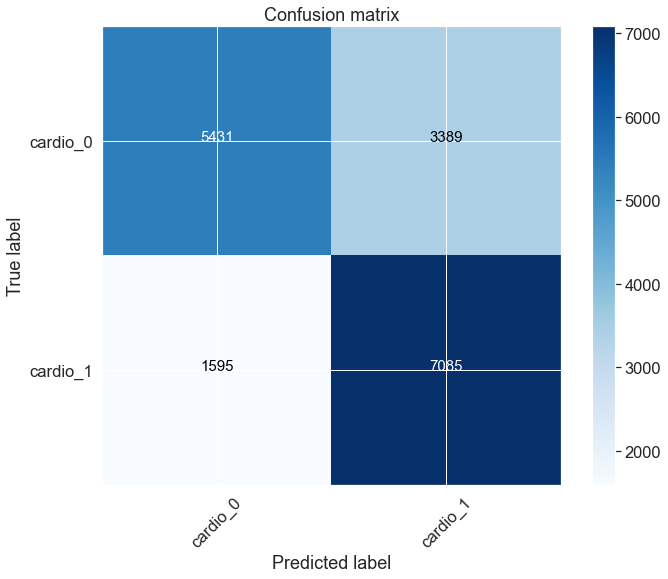

In [29]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, y_score_gb > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [30]:
TN = cnf_matrix_gb[0][0]
FN = cnf_matrix_gb[1][0]
TP = cnf_matrix_gb[1][1]
FP = cnf_matrix_gb[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.8162442396313364, 0.38424036281179136, 0.6157596371882086)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152322600
Расходы "решение не делать тесты - расходы с МL:" 21277400
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 2377400


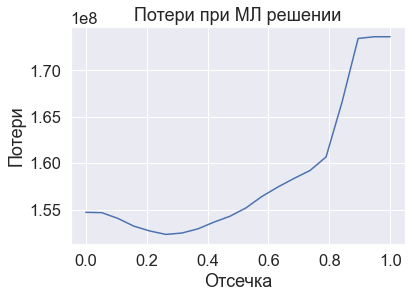

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.365865538275279


In [31]:
busines_tr = business_threshold_calibrate(y_test, y_score_gb, 
                                          thresholds[ix],
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds[ix])

In [32]:
fin_dict

{'model': ['LogReg', 'GradBoost'],
 'F-score': [0.7303229695112764, 0.7398590446358653],
 'Precision': [0.6474307596402173, 0.6764677804295943],
 'Recall': [0.8375576036866359, 0.8163594470046083],
 'ROC-AUC-SCORE': [0.7840347790421852, 0.8028052668840193]}

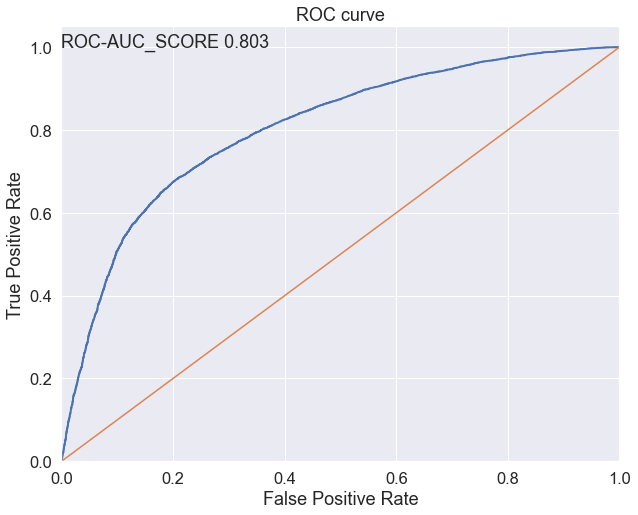

In [33]:
roc_auc_plot(y_test, y_score_gb)

### RandomForestClassifier

In [34]:
parameters = {
     'n_estimators': [150, 200, 300, 400, 600, 800, 1000],
     'max_depth': np.arange(5, 20, 2),
 }
clf = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=parameters, scoring='roc_auc', cv=5)
clf.fit(X_train, y_train)
clf.best_params_

KeyboardInterrupt: 

In [35]:
classifier_RF = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=800, max_depth=11, random_state=0))])

In [36]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_RF, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print(f'CV score is {cv_score}+-{cv_score_std}')

#обучим пайплайн на всем тренировочном датасете
classifier_RF.fit(X_train, y_train)
y_score_rf = classifier_RF.predict_proba(X_test)[:, 1]

CV score is 0.8020126827832292+-0.006997592210458914


In [37]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_rf)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]: .3f}, Precision={precision[ix]: .3f}, Recall={recall[ix]: .3f}')
new_list=['RF',fscore[ix],precision[ix], recall[ix], roc_auc_score(y_test, y_score_rf), bi]
for i, (key, val) in enumerate(fin_dict.items()):
    fin_dict[key].append(new_list[i])

Best Threshold=0.3978821927188207, F-Score= 0.740, Precision= 0.697, Recall= 0.789


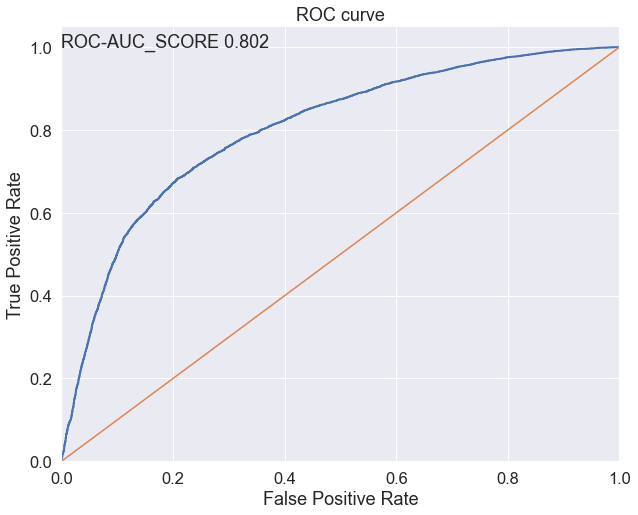

In [38]:
roc_auc_plot(y_test, y_score_rf)

Confusion matrix, without normalization
[[5845 2975]
 [1835 6845]]


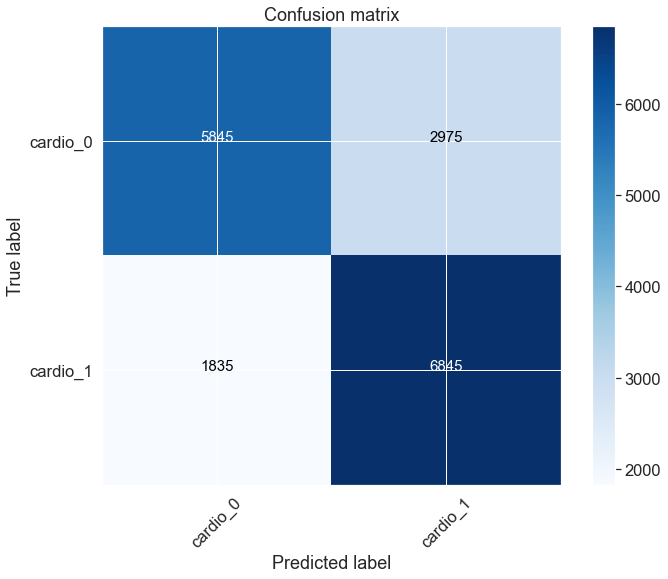

In [39]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, y_score_rf > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")

In [40]:
TN = cnf_matrix_rf[0][0]
FN = cnf_matrix_rf[1][0]
TP = cnf_matrix_rf[1][1]
FP = cnf_matrix_rf[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.788594470046083, 0.3373015873015873, 0.6626984126984127)

расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000
расходы, если использовать МЛ: 152399800
Расходы "решение не делать тесты - расходы с МL:" 21200200
Расходы "решение не делать тесты - расходы сделать тесты всем": 18900000
Расходы "сделать тесты всем - решение делать тесты ML": 2300200


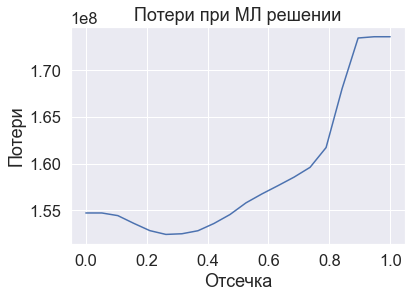

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.3978821927188207


In [41]:
busines_tr = business_threshold_calibrate(y_test, y_score_rf, 
                                          thresholds[ix],
                                          rubl_test=1400, 
                                          rubl_early_treatment=15000, 
                                          rubl_late_treatment=20000)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds[ix])

In [ ]:
fin_dict={
    'model':['LogReg'],
    'F-score':[fscore[ix]],
    'Precision':[precision[ix]],
    'Recall':[recall[ix]]
}

In [42]:
res=pd.DataFrame(fin_dict).set_index('model')

In [43]:
res

,F-score,Precision,Recall,ROC-AUC-SCORE
model,,,,
LogReg,0.730323,0.647431,0.837558,0.784035
GradBoost,0.739859,0.676468,0.816359,0.802805
RF,0.740068,0.697078,0.788710,0.801860


Для данной задачи наиболее важным показателем является полнота. Нам важно не пропустить ни одного пациента имеющего заболевание. Поэтому из данных моделей лучше всего справились с задачей модель логистической регрессии, и градиентный бустинг.

В случае наличия сильного дисбалланса классов более правильно использовать метрику precision_recall_curve. Причина этого заключается в том, что, большое количество примеров класса 0 означает, что мы менее заинтересованы в умении модели правильно предсказывать класс 0, например высокие истинные негативы. А при расчете точности и полноты не используются истинные негативы. Это касается только правильного предсказания класса меньшинства, класса 1. При этом roc_auc_curve будет давать более оптимистичную оценку модели, слабо реагируя на соотношение классов.

 

Если смотреть по бизнесовой метрике то лучше всего показывает себя случайный лес и градиентный бустинг. Лучше всего экономят денег больнице